Using device: cuda
Epoch 0 | Loss 15.587318
Epoch 500 | Loss 0.513108
Epoch 1000 | Loss 0.128262
Epoch 1500 | Loss 0.067957
Epoch 2000 | Loss 0.055075
Epoch 2500 | Loss 0.040007
Epoch 3000 | Loss 0.036180
Epoch 3500 | Loss 0.033838
Epoch 4000 | Loss 0.031984
Epoch 4500 | Loss 0.030458
Epoch 5000 | Loss 0.028776
Epoch 5500 | Loss 0.027093
Epoch 6000 | Loss 0.025875
Epoch 6500 | Loss 0.024099
Epoch 7000 | Loss 0.022565
Epoch 7500 | Loss 0.021172
Epoch 8000 | Loss 0.019814
Epoch 8500 | Loss 0.018512
Epoch 9000 | Loss 0.017435
Epoch 9500 | Loss 0.016386
Epoch 10000 | Loss 0.015451
Epoch 10500 | Loss 0.020556
Epoch 11000 | Loss 0.015608
Epoch 11500 | Loss 0.014604
Epoch 12000 | Loss 0.013909
Epoch 12500 | Loss 0.013614
Epoch 13000 | Loss 0.012654
Epoch 13500 | Loss 0.012134
Epoch 14000 | Loss 0.011678
Epoch 14500 | Loss 0.011150
Epoch 15000 | Loss 0.010904
Epoch 15500 | Loss 0.010300
Epoch 16000 | Loss 0.009887
Epoch 16500 | Loss 0.009569
Epoch 17000 | Loss 0.009710
Epoch 17500 | Loss 0.008

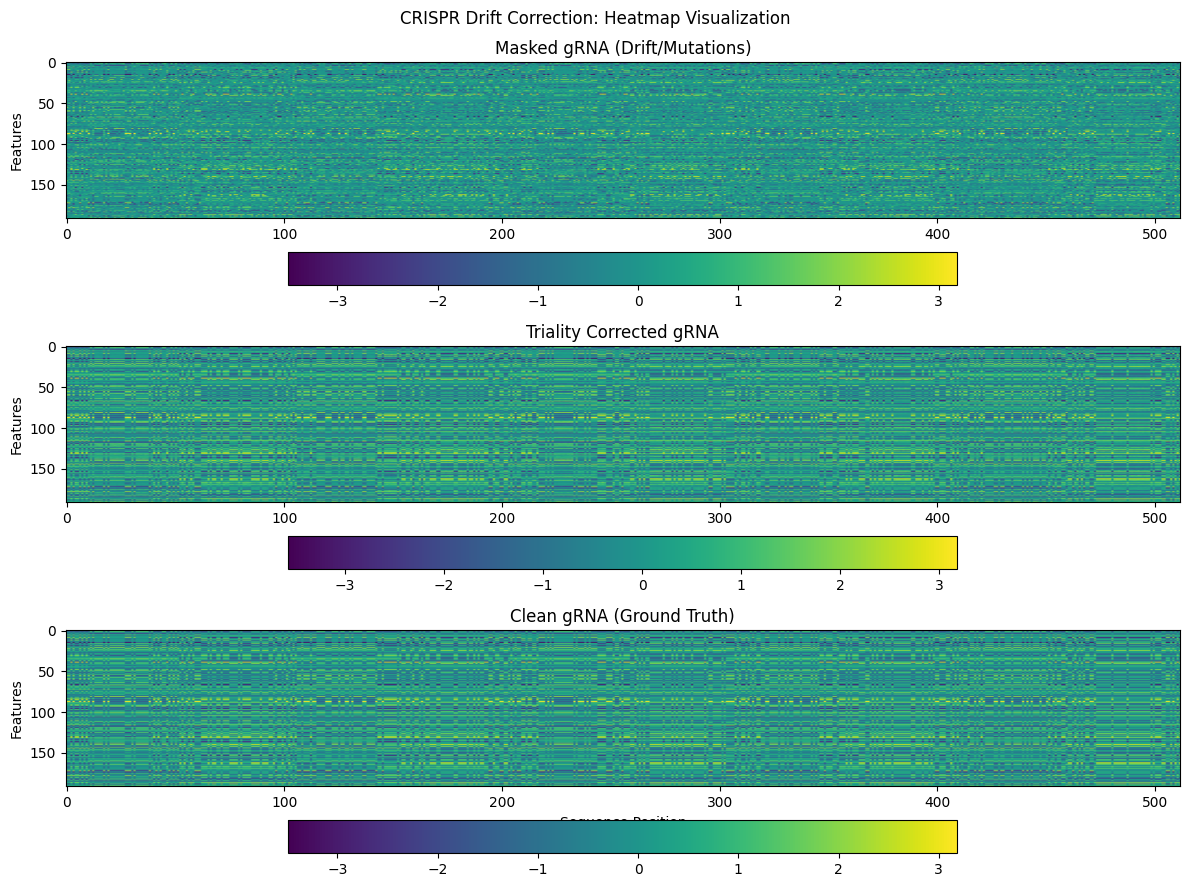

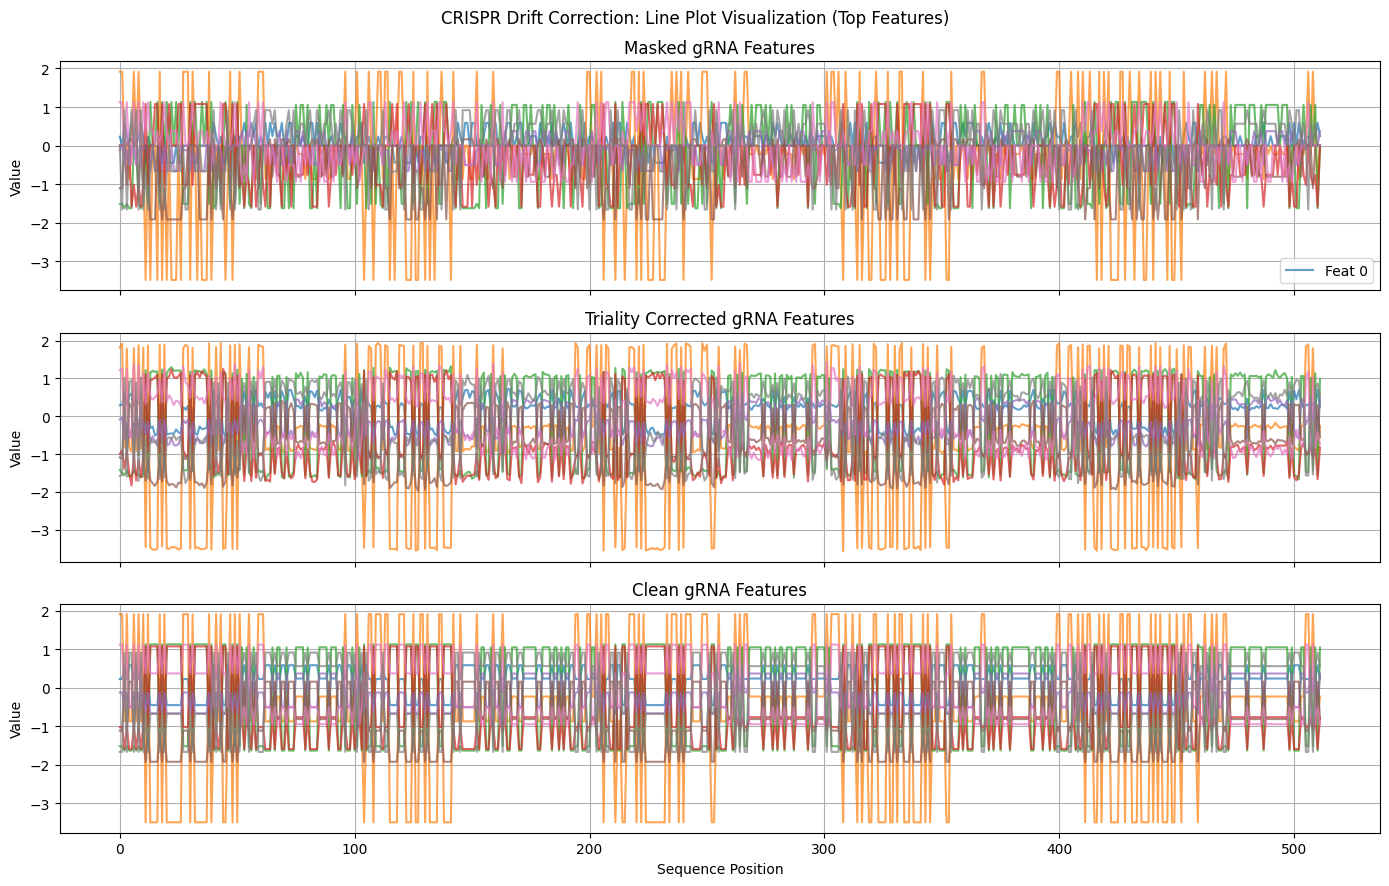

Heatmap and line plot visualizations displayed above


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
from contextlib import nullcontext
import math

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for Colab/Gemini speed (fast epochs, no OOM)
triality = 3
dim = 192  # reduced
latent_dim = 8
seq_len = 512  # gRNA sequence length proxy
batch_size = 16  # reduced
epochs = 20000
lr = 5e-5
use_amp = True
use_checkpoint = False # Changed to False for debugging

# Synthetic CRISPR gRNA proxy (real-like sequences + drift/noise)
# Mimics 20-nt guide RNA + PAM, with mutations/off-target drift
alphabet = torch.tensor([0, 1, 2, 3], device=device)  # A, C, G, T proxy
gRNAs = []
for b in range(batch_size):
    # Base coherent gRNA (repeating pattern + noise)
    base = torch.sin(torch.linspace(0, 10*math.pi, seq_len, device=device)) * 1.5 + 2
    base = base % 4
    gRNA = base.long() + torch.randint(-1, 2, (seq_len,), device=device)  # drift/mutations
    gRNA = torch.clamp(gRNA, 0, 3)
    gRNAs.append(gRNA)

gRNAs = torch.stack(gRNAs).to(device)  # (batch, seq_len)

# One-hot embed to dim (4 bases → dim)
embed = nn.Embedding(4, dim).to(device)
real_data_initial = embed(gRNAs)  # (batch, seq_len, dim)

# Apply masking (40–70% drift/missing bases — off-target/mutation proxy)
missing_rate = torch.linspace(0.4, 0.7, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(real_data_initial) < missing_rate
real_data_initial[mask] = 0

# Detach real_data and target since they are fixed inputs for the model training loop
real_data = real_data_initial.detach()
target = embed(gRNAs).detach()

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (detached step + fixed pump broadcast)
class CRISPRCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]  # (seq_len, 8)
        low_dim = self.proj(pos_emb)  # (seq_len, dim//3)
        emb = low_dim.repeat(1, triality)  # (seq_len, dim)
        # Detached pump scalar
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)  # (1, seq_len, 1)
        emb_broadcast = emb.unsqueeze(0)  # (1, seq_len, dim)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()  # roll along seq_len
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Model (reduced depth for speed)
class E8CRISPRFusion(nn.Module):
    def __init__(self, depth=16):
        super().__init__()
        self.cycle = CRISPRCycleBlock()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + self.norm(attn)
        return x

model = E8CRISPRFusion().to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    opt.zero_grad(set_to_none=True)

    # Clone real_data and target inside the loop to ensure fresh tensors
    # and avoid potential graph retention issues from previous epochs.
    current_real_data = real_data.clone()
    current_target = target.clone()

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(current_real_data, epoch)
        loss = loss_fn(recon, current_target)

    scaler.scale(loss).backward() if use_amp else loss.backward()
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss {loss.item():.6f}")

# Heatmap + Line Plot Visualization (gRNA "drift" features)
with torch.no_grad():
    recon = model(real_data, 0).cpu()
    original = real_data.cpu()
    clean = target.cpu()

# First batch sample
masked = original[0].numpy()  # (seq_len, dim)
reconstructed = recon[0].numpy()
clean_gRNA = clean[0].numpy()

time = np.arange(seq_len)

# Heatmaps (dim as "features")
fig, axes = plt.subplots(3, 1, figsize=(12, 9))
im1 = axes[0].imshow(masked.T, aspect='auto', cmap='viridis')
axes[0].set_title("Masked gRNA (Drift/Mutations)")
axes[0].set_ylabel("Features")
fig.colorbar(im1, ax=axes[0], orientation='horizontal')

im2 = axes[1].imshow(reconstructed.T, aspect='auto', cmap='viridis')
axes[1].set_title("Triality Corrected gRNA")
axes[1].set_ylabel("Features")
fig.colorbar(im2, ax=axes[1], orientation='horizontal')

im3 = axes[2].imshow(clean_gRNA.T, aspect='auto', cmap='viridis')
axes[2].set_title("Clean gRNA (Ground Truth)")
axes[2].set_ylabel("Features")
axes[2].set_xlabel("Sequence Position")
fig.colorbar(im3, ax=axes[2], orientation='horizontal')

plt.suptitle("CRISPR Drift Correction: Heatmap Visualization")
plt.tight_layout()
plt.show()

# Line Plots (top 8 features as gRNA "bases")
num_features = 8
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

for c in range(num_features):
    axes[0].plot(time, masked[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[0].set_title("Masked gRNA Features")
axes[0].set_ylabel("Value")
axes[0].grid(True)
axes[0].legend()

for c in range(num_features):
    axes[1].plot(time, reconstructed[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[1].set_title("Triality Corrected gRNA Features")
axes[1].set_ylabel("Value")
axes[1].grid(True)

for c in range(num_features):
    axes[2].plot(time, clean_gRNA[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[2].set_title("Clean gRNA Features")
axes[2].set_ylabel("Value")
axes[2].set_xlabel("Sequence Position")
axes[2].grid(True)

plt.suptitle("CRISPR Drift Correction: Line Plot Visualization (Top Features)")
plt.tight_layout()
plt.show()

print("Heatmap and line plot visualizations displayed above")